In [18]:
import time

import pyproj
import shapely
import numpy as np
import pandas as pd
from tqdm import tqdm

import gmaps
import geopandas as gpd

In [2]:
# Authenticate the API Key.
key_path = "/Users/administrator/Documents/Projects/abq_crime/api_key.txt"
with open(key_path) as f:
    api_key = f.readline()
    f.close()

# Initialize a session.
gmaps.configure(api_key=api_key)

In [3]:
# Utility functions.
def convert_coordinates(coordinates, transformer=None):
    """Converts coordinates from the EPSG:2258 standard to the EPSG:4326 standard.

    Parameters
    ----------
    coordinates : tuple (int, int)
        Tuple containing the coordinates in the EPSG:2258 standard.
    transformer : pyproj.transformer.Transformer instance
        Instance of a pyproj transformer used for converting the coordinates, by default None. If no transformer is specified, then the default transformer that converts EPSG:2258 to EPSG:4326 is used.

    Returns
    -------
    trans_coordinates : tuple (int, int)
        Tuple containing the coordinates in the EPSG:4326 standard.

    """
    if transformer is None:
        transformer = pyproj.Transformer.from_crs("epsg:2258", "epsg:4326")

    trans_coordinates = transformer.transform(coordinates[0], coordinates[1])

    return trans_coordinates

def batch_convert_coordinates(coord_list, transformer=None):
    """Converts a batch of coordinates from the EPSG:2258 standard to the EPSG:4326 standard.

    Parameters
    ----------
    coord_list : list of tuples (int, int)
        List containing tuples containing the coordinates in the EPSG:2258 standard.
    transformer : pyproj.transformer.Transformer instance
        Instance of a pyproj transformer used for converting the coordinates, by default None. If no transformer is specified, then the default transformer that converts EPSG:2258 to EPSG:4326 is used.

    Returns
    -------
    trans_coord_list : list of tuples (int, int)
        List containing tuples of coordinates in the EPSG:4326 standard.

    """
    if transformer is None:
        transformer = pyproj.Transformer.from_crs("epsg:2258", "epsg:4326")

    trans_coord_list = list()
    for coord in coord_list:
        trans_coord_list.append(convert_coordinates(coord, transformer=transformer))

    return trans_coord_list

In [4]:
# Load the zipcode shapefile.
shapefile_path = "/Users/administrator/Documents/Projects/abq_crime/shapefiles/zipcodes/zipcodes.shp"
zipcodes_shapefile = gpd.read_file(shapefile_path)

# Keep only the relevant columns.
keep_columns = ["ZIPCODE", "geometry"]
zipcodes_shapefile = zipcodes_shapefile[keep_columns]

# Get the indices of the zip codes that have separated convex sets.
mpolygon_indices = [type(entry) == shapely.geometry.multipolygon.MultiPolygon for entry in zipcodes_shapefile["geometry"]]
mpolygon_indices = [idx for idx, entry in enumerate(mpolygon_indices) if entry == True]


In [5]:
# For the indices above, create new entries at the end of the DataFrame containing the zipcode and geometry.
# Can use the iloc method to grab the entry in question.
append_list = list()
start_time = time.time()
for index in mpolygon_indices:
    zipcode = zipcodes_shapefile.iloc[index]["ZIPCODE"]
    for poly in zipcodes_shapefile.iloc[index]["geometry"]:
        append_list.append((zipcode, poly))
end_time = time.time()

print("Entire operation took {} seconds.".format(end_time - start_time))

Entire operation took 0.0036230087280273438 seconds.


In [6]:
append_list

[(87116, <shapely.geometry.polygon.Polygon at 0x7fd20deb9550>),
 (87116, <shapely.geometry.polygon.Polygon at 0x7fd20deb9460>)]

In [7]:
# Add to the DataFrame.
for item in append_list:
    zipcodes_shapefile.loc[len(zipcodes_shapefile)] = item

# Delete the original entry.
zipcodes_shapefile.drop(mpolygon_indices, axis=0, inplace=True)
zipcodes_shapefile.reset_index(drop=True, inplace=True)

# See if it is good.
print(zipcodes_shapefile)

    ZIPCODE                                           geometry
0     87026  POLYGON ((1431957.874 1535487.031, 1431957.874...
1     87048  POLYGON ((1517118.876 1533412.031, 1517062.874...
2     87015  POLYGON ((1670405.876 1429902.031, 1654045.874...
3     87114  POLYGON ((1418289.874 1503967.031, 1418468.874...
4     87120  POLYGON ((1519373.874 1518146.031, 1517426.874...
5     87115  POLYGON ((1573879.874 1428887.031, 1575437.874...
6     87104  POLYGON ((1517424.874 1488780.031, 1517297.876...
7     87047  POLYGON ((1637050.874 1517579.031, 1637093.874...
8     87121  POLYGON ((1504327.106 1493091.789, 1504348.524...
9     87068  POLYGON ((1453961.899 1470688.578, 1454190.546...
10    87131  POLYGON ((1530490.874 1491275.031, 1530468.874...
11    87102  POLYGON ((1521205.324 1495789.213, 1521604.184...
12    87112  POLYGON ((1556493.361 1497733.401, 1556506.249...
13    87107  POLYGON ((1529367.874 1513436.031, 1529158.874...
14    87113  POLYGON ((1548633.043 1521467.381, 1548631

In [9]:
# Convert the coordinates.
zipcode_polygons = list()
for idx in tqdm(range(len(zipcodes_shapefile["geometry"]))):
    zipcode_polygons.append(batch_convert_coordinates(zipcodes_shapefile["geometry"][idx].exterior.coords[:]))

100%|██████████| 28/28 [00:05<00:00,  5.09it/s]


In [11]:
# Create a list of gmaps Polygons for plotting.
drawing_list = list()
for polygon_coords in tqdm(zipcode_polygons):
    drawing_list.append(gmaps.Polygon(polygon_coords, stroke_color="red", fill_color=(217, 136, 128),))

100%|██████████| 28/28 [00:00<00:00, 72.70it/s]



### Assigning Weights

* We assign weights to each of the individual Polygons to create a map that is representative of how high the crime rate is.

In [13]:
# Load the data.
data_path = "/Users/administrator/Documents/Projects/abq_crime/data/processed_dataframe.pkl"
dataframe = pd.read_pickle(data_path)

In [90]:
# Extract the latitude and longitude information.
coords_dataframe = dataframe[["Latitude", "Longitude"]]
coords_dataframe.dropna(inplace=True)
coords_dataframe

,Latitude,Longitude
0,35.078682,-106.637350
1,35.121313,-106.701621
2,35.174464,-106.673685
3,35.109201,-106.609120
4,35.078682,-106.637350
...,...,...
29995,35.124129,-106.587242
29996,35.068251,-106.498303
29997,35.050188,-106.635215
29998,35.070992,-106.749786


In [19]:
# Find the zip code where it belongs. Store this information in a Numpy array.
counts = np.zeros(len(zipcode_polygons))

(28,)

In [34]:
# Test cell: tests membership of points.
coords_array = coords_dataframe.to_numpy()

# Example point
point = shapely.geometry.Point(coords_array[0][0], coords_array[0][1])
print(point)

# Example polygon
polygon = zipcodes_shapefile.iloc[0]["geometry"]

# Check membership.
for idx in range(len(zipcodes_shapefile)):
    if zipcodes_shapefile.iloc[idx]["geometry"].contains(point):
        print(idx)

POINT (35.07868196140473 -106.6373501693855)


In [46]:
# Test cell: tests membership of points.
zipcode_polygons_object = [shapely.geometry.Polygon(entry) for entry in zipcode_polygons]

for idx in range(len(zipcode_polygons_object)):
    if zipcode_polygons_object[idx].contains(point):
        print(idx)

21


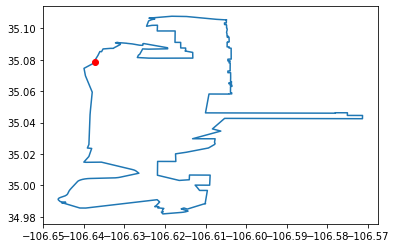

In [71]:
# Test cell: tests membership of points.
plt.plot(*zipcode_polygons_object[21].exterior.xy[::-1])
plt.plot(*point.xy[::-1], "ro")

In [93]:
def test_membership(coords):
    point = shapely.geometry.Point(coords[0], coords[1])
    for idx in range(len(zipcode_polygons_object)):
        if zipcode_polygons_object[idx].contains(point):
            return idx
    return -1

In [94]:
for row in tqdm(coords_dataframe.itertuples()):
    coord = (row[1], row[2])
    zip_index = test_membership(coord)
    if (zip_index != -1):
        counts[zip_index] += 1

28876it [00:08, 3509.05it/s]


In [97]:
counts = counts / counts.sum()

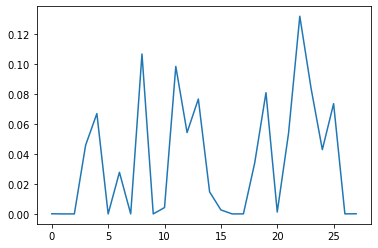

In [98]:
plt.plot(counts)

In [108]:
# Plot the Polygons with their weights.
drawing_list = list()
for idx, polygon_coords in enumerate(tqdm(zipcode_polygons)):
    drawing_list.append(gmaps.Polygon(polygon_coords, stroke_color="black", stroke_opacity=0.2, fill_color=(255, 0, 0), fill_opacity=4 * counts[idx]))

100%|██████████| 28/28 [00:00<00:00, 67.64it/s]


In [110]:
# Plot the Polygons using gmaps.
fig = gmaps.figure(center=(35.08541434188005, -106.65083179442777), zoom_level=12)
drawing = gmaps.drawing_layer(features=drawing_list, show_controls=False,)
fig.add_layer(drawing)
fig

Figure(layout=FigureLayout(height='420px'))

In [115]:
# Check areas that have a count of zero.
[idx for idx, elem in enumerate(counts) if elem == 0]

# Indeed, the zip codes with index 1, 2, 5, 9, 16 do not have data, so we should remove them! This should be accounted for in the analysis.

[1, 2, 5, 9, 16]

### Remove the Empty Entries from the Analysis

In [ ]:
import os
import time

import numpy as np
import pandas as pd

import gmaps
import geopandas as gpd